In [1]:
%pip install requests pandas numpy matplotlib seaborn cvxpy openpyxl scikit-learn SyntheticControlMethods

# Make sure that the scipy version is 1.4.1 for the SyntheticControlMethods package
%pip uninstall scipy -y
%pip install scipy==1.4.1

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.


GDP Indicator: NGDP_NSA_XDC
Successfully retrieved data using the IMF Data API
GH.PCPI_IX has 56 observations
KE.PCPI_IX has 56 observations
MU.PCPI_IX has 56 observations
GH.ENDE_XDC_USD_RATE has 56 observations
DZ.ENDE_XDC_USD_RATE has 56 observations
EG.ENDE_XDC_USD_RATE has 55 observations
NA.PCPI_IX has 56 observations
KE.ENDE_XDC_USD_RATE has 56 observations
RW.PCPI_IX has 56 observations
ZA.PCPI_IX has 56 observations
DZ.PCPI_IX has 56 observations
SC.PCPI_IX has 47 observations
NG.ENDE_XDC_USD_RATE has 55 observations
SC.ENDE_XDC_USD_RATE has 52 observations
EG.PCPI_IX has 56 observations
MU.ENDE_XDC_USD_RATE has 56 observations
RW.ENDE_XDC_USD_RATE has 56 observations
NG.PCPI_IX has 55 observations
ZA.ENDE_XDC_USD_RATE has 56 observations
NA.ENDE_XDC_USD_RATE has 56 observations
RW.FITB_PA has 56 observations
KE.FITB_PA has 56 observations
DZ.FIDR_PA has 56 observations
MU.FITB_PA has 56 observations
KE.FIDR_PA has 56 observations
ZA.FITB_PA has 56 observations
KE.FILR_PA has 

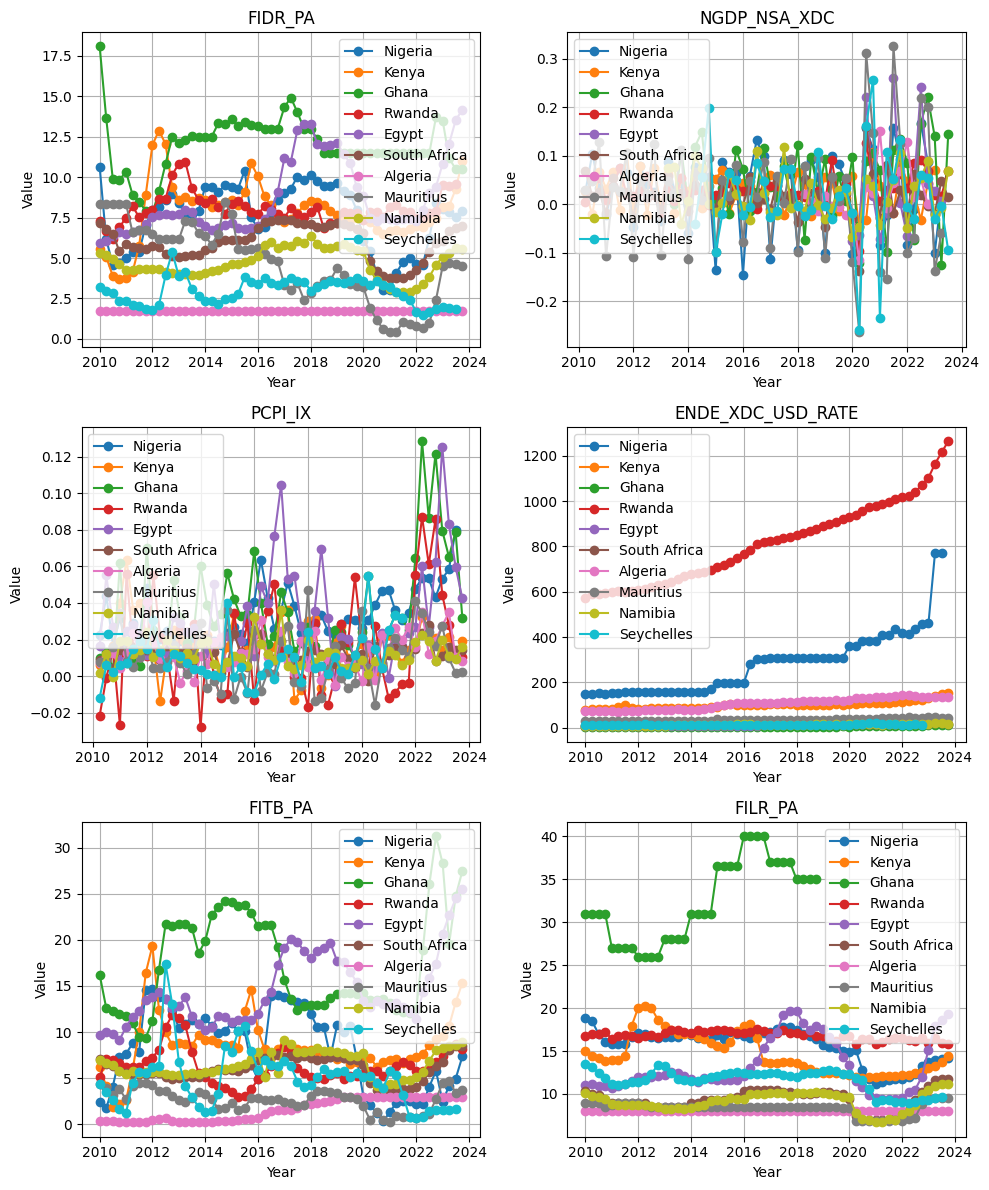

In [352]:
import requests
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

# GLOBAL VARIABLES

FREQUENCY = 'Q' # 'M' for monthly, 'Q' for quarterly, 'A' for annual
START_PERIOD = 2010
END_PERIOD = 2024

# The Bahamas
# TREATMENT_UNIT = 'BS'
TREATMENT_UNIT = 'NG'

# Antigua and Barbuda, Barbados, Belize, Dominica, Fiji, Grenada, Mauritius, Trinidad and Tobago, Saint Vincent and the Grenadines
# CONTROL_UNITS = ['AG', 'BB', 'BZ', 'DM', 'GD', 'HK', 'VC']
# CONTROL_UNITS = ['KE', 'GH', 'ID', 'RW']

# # Without interest rates
# CONTROL_UNITS = [
#     'KE', 'GH', 'BD', 'ID', 'RW',
#     'MZ', 'EG', 'ZA', 'DZ', 'MA',
#     'AO', 'CD', 'GN', 'BF', 'BW',
#     'BJ', 'MG', 'MU', 'NA', 'SL',
#     'CV', 'SC', 'KM'
# ]
# # GH EG AO SL
# 0.01799951 0.2923744 0.01722074 0.007840782 0.01199338
# 0.01795878 0.0524789 0.01561187 0.01412409 0.01010163
# 0.3759583 0.01197117 0.01497519 0.00867674 0.01490292
# 0.008797611 0.01289472 0.01227155 0.01520208 0.03488117
# 0.009672243 0.01317007 0.008922164

# With interest rates
# CONTROL_UNITS = [
#     'KE', 'GH', 'BD', 'EG', 'ZA',
#     'AO', 'MU', 'SL', 'CV'
# ]

# # With interest rates, no Central Bank
# CONTROL_UNITS = [
#     'KE', 'GH', 'BD', 'RW',
#     'MZ', 'EG', 'ZA', 'DZ',
#     'AO', 'MG', 'MU', 'NA',
#     'SL', 'CV', 'SC'
# ]

# Quarterly - With interest rates, no Central Bank
CONTROL_UNITS = [
    'KE', 'GH', 'RW',
    'EG', 'ZA', 'DZ',
    'MU', 'NA', 'SC'
]

COUNTRIES = [TREATMENT_UNIT] + CONTROL_UNITS
COUNTRIES_KEY = '+'.join(COUNTRIES)

COUNTRY_CODE = {country: index for index, country in enumerate(COUNTRIES, start=1)}

COUNTRY_NAME = {
    'BS': 'The Bahamas',
    'AG': 'Antigua and Barbuda',
    'BB': 'Barbados',
    'BZ': 'Belize',
    'DM': 'Dominica',
    'FJ': 'Fiji',
    'GD': 'Grenada',
    'MU': 'Mauritius',
    'TT': 'Trinidad and Tobago',
    'VC': 'Saint Vincent and the Grenadines',
    'HK': 'Hong Kong',
    'BH': 'Bahrain',
    'DJ': 'Djibouti',
    'PA': 'Panama',
    ########################################
    'NG': 'Nigeria',
    'KE': 'Kenya',
    'GH': 'Ghana',
    'CI': 'Cote d\'Ivoire',
    'SN': 'Senegal',
    'ET': 'Ethiopia',
    'BD': 'Bangladesh',
    'VT': 'Vietnam',
    'PH': 'Philippines',
    'PK': 'Pakistan',
    'ID': 'Indonesia',
    'CM': 'Cameroon',
    'TZ': 'Tanzania',
    'RW': 'Rwanda',
    'UG': 'Uganda',
    'MZ': 'Mozambique',
    'ZM': 'Zambia',
    'ZW': 'Zimbabwe',
    "EG": "Egypt",
    "ZA": "South Africa",
    "DZ": "Algeria",
    "MA": "Morocco",
    "AO": "Angola",
    "CD": "Democratic Republic of the Congo",
    "TN": "Tunisia",
    "LY": "Libya",
    "SD": "Sudan",
    "GN": "Guinea",
    "ML": "Mali",
    "BF": "Burkina Faso",
    "BW": "Botswana",
    "BJ": "Benin",
    "GA": "Gabon",
    "NE": "Niger",
    "MG": "Madagascar",
    "CG": "Republic of the Congo",
    "MW": "Malawi",
    "NA": "Namibia",
    "TD": "Chad",
    "SO": "Somalia",
    "MR": "Mauritania",
    "GQ": "Equatorial Guinea",
    "TG": "Togo",
    "SS": "South Sudan",
    "LR": "Liberia",
    "SL": "Sierra Leone",
    "BI": "Burundi",
    "CF": "Central African Republic",
    "CV": "Cape Verde",
    "GM": "The Gambia",
    "SC": "Seychelles",
    "GW": "Guinea-Bissau",
    "ER": "Eritrea",
    "KM": "Comoros"
}

# Deposits Interest Rate
OUTPUT = 'FIDR_PA'

GDP_INDICATOR = 'NGDP_XDC' if FREQUENCY == 'A' else 'NGDP_NSA_XDC'
print(f"GDP Indicator: {GDP_INDICATOR}")

# GDP, Inflation Rate, Exchange Rate to USD, Treasury Bills, Savings Rate, Lending Rate
INPUTS = [GDP_INDICATOR, 'PCPI_IX', 'ENDE_XDC_USD_RATE', 'FITB_PA', 'FILR_PA'] #, 'FPOLM_PA']

INDICATORS = [OUTPUT] + INPUTS
INDICATORS_KEY = '+'.join(INDICATORS)

# IMF DATA API
KEY = f'CompactData/IFS/{FREQUENCY}.{COUNTRIES_KEY}.{INDICATORS_KEY}?startPeriod={START_PERIOD}&endPeriod={END_PERIOD}'
URL = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
REQUEST_URL = f'{URL}{KEY}'

# FUNCTIONS

def calculate_growth_rate(values):
    """Calculate the year-over-year growth rate, handling NaN values."""
    growth_rates = [np.nan]  # Initialize with NaN since the first year does not have a previous year to compare to.
    for i in range(1, len(values)):
        # Calculate growth rate only if both current and previous values are not NaN.
        if not np.isnan(values[i]) and not np.isnan(values[i-1]) and values[i-1] != 0:
            growth_rate = (values[i] - values[i-1]) / values[i-1]
        else:
            growth_rate = np.nan
        growth_rates.append(growth_rate)
    return growth_rates

def convert_to_decimal(date_str):
    year_part, quarter_part = date_str.split('-Q')
    year_part = int(year_part)
    quarter_part = float(quarter_part)
    return year_part + (quarter_part - 1) / 4.0

# MAIN

try:
    response = requests.get(REQUEST_URL)
except Exception as e:
    print("Failed to retrieve data using the IMF Data API; Error:", e)
    sys.exit()
if response.status_code != 200:
    print(f"Failed to retrieve data using the IMF Data API; Response code: {response.status_code}")
    sys.exit()

print("Successfully retrieved data using the IMF Data API")

data = {}
for country in COUNTRIES:
    data[country] = {}

try:
    series = response.json()['CompactData']['DataSet']['Series']

    for s in series:
        country = s['@REF_AREA']
        indicator = s['@INDICATOR']

        if 'Obs' not in s:
            print(f"No data found for {country}.{indicator}")
            continue

        print(f"{country}.{indicator} has {len(s['Obs'])} observations")

        observations = s['Obs']
        times = [obs.get('@TIME_PERIOD') for obs in observations]
        values = [float(obs.get('@OBS_VALUE')) if obs.get('@OBS_VALUE') else np.nan for obs in observations]

        # Check if we need to calculate growth rates for GDP and Inflation Rate indicators
        if indicator in ['NGDP_XDC', 'NGDP_NSA_XDC', 'NGDP_R_XDC', 'NGDP_R_NSA_XDC', 'PCPI_IX']:
            values = calculate_growth_rate(values)

        data[country][indicator] = list(zip(times, values))

except Exception as e:
    print("Failed to process data; Error:", e)
    sys.exit()

# Add manual data for Ghana Lending Rates from https://tradingeconomics.com/ghana/bank-lending-rate
if FREQUENCY == 'A':
    data['GH']['FILR_PA'] = [
        ('2010', 31), ('2011', 27), ('2012', 26), ('2013', 28),
        ('2014', 31), ('2015', 36.5), ('2016', 40), ('2017', 37),
        ('2018', 35)
    ]
else:
    data['GH']['FILR_PA'] = [
        ('2010-Q1', 31), ('2010-Q2', 31), ('2010-Q3', 31), ('2010-Q4', 31),
        ('2011-Q1', 27), ('2011-Q2', 27), ('2011-Q3', 27), ('2011-Q4', 27),
        ('2012-Q1', 26), ('2012-Q2', 26), ('2012-Q3', 26), ('2012-Q4', 26),
        ('2013-Q1', 28), ('2013-Q2', 28), ('2013-Q3', 28), ('2013-Q4', 28),
        ('2014-Q1', 31), ('2014-Q2', 31), ('2014-Q3', 31), ('2014-Q4', 31),
        ('2015-Q1', 36.5), ('2015-Q2', 36.5), ('2015-Q3', 36.5), ('2015-Q4', 36.5),
        ('2016-Q1', 40), ('2016-Q2', 40), ('2016-Q3', 40), ('2016-Q4', 40),
        ('2017-Q1', 37), ('2017-Q2', 37), ('2017-Q3', 37), ('2017-Q4', 37),
        ('2018-Q1', 35), ('2018-Q2', 35), ('2018-Q3', 35), ('2018-Q4', 35)
    ]

# PLOT DATA

# Determine the layout of the subplot grid
num_indicators = len(INDICATORS)
num_columns = 2  # Or any other number you wish
num_rows = (num_indicators + num_columns - 1) // num_columns  # This ensures enough rows

plt.figure(figsize=(5 * num_columns, 4 * num_rows))

# Create a subplot for each indicator
for i, indicator in enumerate(INDICATORS, start=1):
    ax = plt.subplot(num_rows, num_columns, i)

    # Track if we have added any data to plot (for cases where an indicator may not be present)
    plotted_data = False

    for country in COUNTRIES:
        # Check if the indicator exists for the country
        if indicator in data[country]:
            plotted_data = True

            # Prepare the data, transforming the date format
            times = [pd.to_datetime(obs[0]) for obs in data[country][indicator]]
            values = [float(obs[1]) if obs[1] else np.nan for obs in data[country][indicator]]

            # Plot the data for the country
            ax.plot(times, values, marker='o', label=COUNTRY_NAME.get(country, country))

    # Customize the subplot
    if plotted_data:
        ax.set_title(indicator)
        ax.set_xlabel('Year')
        ax.set_ylabel('Value')
        ax.grid(True)
        ax.legend()
    else:
        plt.delaxes(ax)  # Remove the subplot if no data is present for the indicator

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()

In [354]:
rows_list = []

# Iterate over each country and its corresponding data
for country, indicators in data.items():
    # Prepare a nested dictionary for each indicator by year
    year_data = {}
    for indicator, observations in indicators.items():
        for obs in observations:
            year, value = obs
            value = float(value) if value else np.nan  # Ensure value is float or NaN
            if year not in year_data:
                year_data[year] = {}
            year_data[year][indicator] = value

    # Now, flatten the year_data dictionary into rows for our DataFrame
    for year, indicators in year_data.items():
        row = {
            'code': COUNTRY_CODE[country],
            'country': country,
            'year': year,
        }
        # Add each indicator's value to the row; if an indicator is missing, the value will be NaN
        row.update(indicators)
        rows_list.append(row)

# Convert the list of rows into a DataFrame
dataframe = pd.DataFrame(rows_list)

# Ensure all indicators are present as columns, filling missing ones with NaN
final_columns = ['code', 'country', 'year'] + INDICATORS
for col in final_columns:
    if col not in dataframe.columns:
        dataframe[col] = np.nan

# Reorder the DataFrame columns as needed
dataframe = dataframe[final_columns]

# TRANSFORM DATE TO INTEGER WHEN USING QUARTERLY DATA
if FREQUENCY == 'Q':
    dataframe['year'] = dataframe['year'].apply(convert_to_decimal)
    dataframe['year'] = dataframe['year'].astype(float)
else:
    dataframe['year'] = dataframe['year'].astype(int)

# Optionally, sort the DataFrame by country and year for better readability
dataframe.sort_values(by=['code', 'year'], inplace=True)

# Save the DataFrame to a CSV file
dataframe.to_csv('data/synthetic-control-dataset.csv', index=False)

print("CSV file created successfully.")

CSV file created successfully.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85027D+01    |proj g|=  8.57143D-01

At iterate    3    f=  2.10532D+01    |proj g|=  8.07228D-01

At iterate    6    f=  2.10367D+01    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      6      8     12     0     4   3.553D-07   2.104D+01
  F =   21.036652037015770     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   48    f=  2.96025D+01    |proj g|=  6.75174D-01

At iterate   51    f=  2.95580D+01    |proj g|=  9.97656D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   54    f=  2.95360D+01    |proj g|=  3.98643D-01
  ys=-4.074E-04  -gs= 2.240E-07 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     57    274     83     2     5   6.277D-01   2.954D+01
  F =   29.535922144213941     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.86337D+01    |proj g|=  9.99916D-01

At iterate    3    f=  3.74059D+01    |proj g|=  9.99716D-01
  ys=-8.915E-08  -gs= 8.690E-04 BFGS update SKIPPED
  Positive dir derivative in projection 
  Using the backtracking step 

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f=  2.13094D+01    |proj g|=  1.00000D+00

At iterate   48    f=  2.10367D+01    |proj g|=  6.39488D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48    145     58     2     1   6.395D-06   2.104D+01
  F =   21.036652037015770     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67503D+01    |proj g|=  9.51229D-01

At iterate    3    f=  2.10387D+01    |proj g|=  9.17181D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   36    f=  2.91507D+01    |proj g|=  1.45851D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   39    f=  2.91498D+01    |proj g|=  1.47932D-01
  ys=-2.439E-03  -gs= 1.800E-06 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42    234     70     2     6   1.480D-01   2.915D+01
  F =   29.149722261729480     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.15673D+01    |proj g|=  8.44082D-01

At iterate    3    f=  2.10367D+01    |proj g|=  4.15668D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

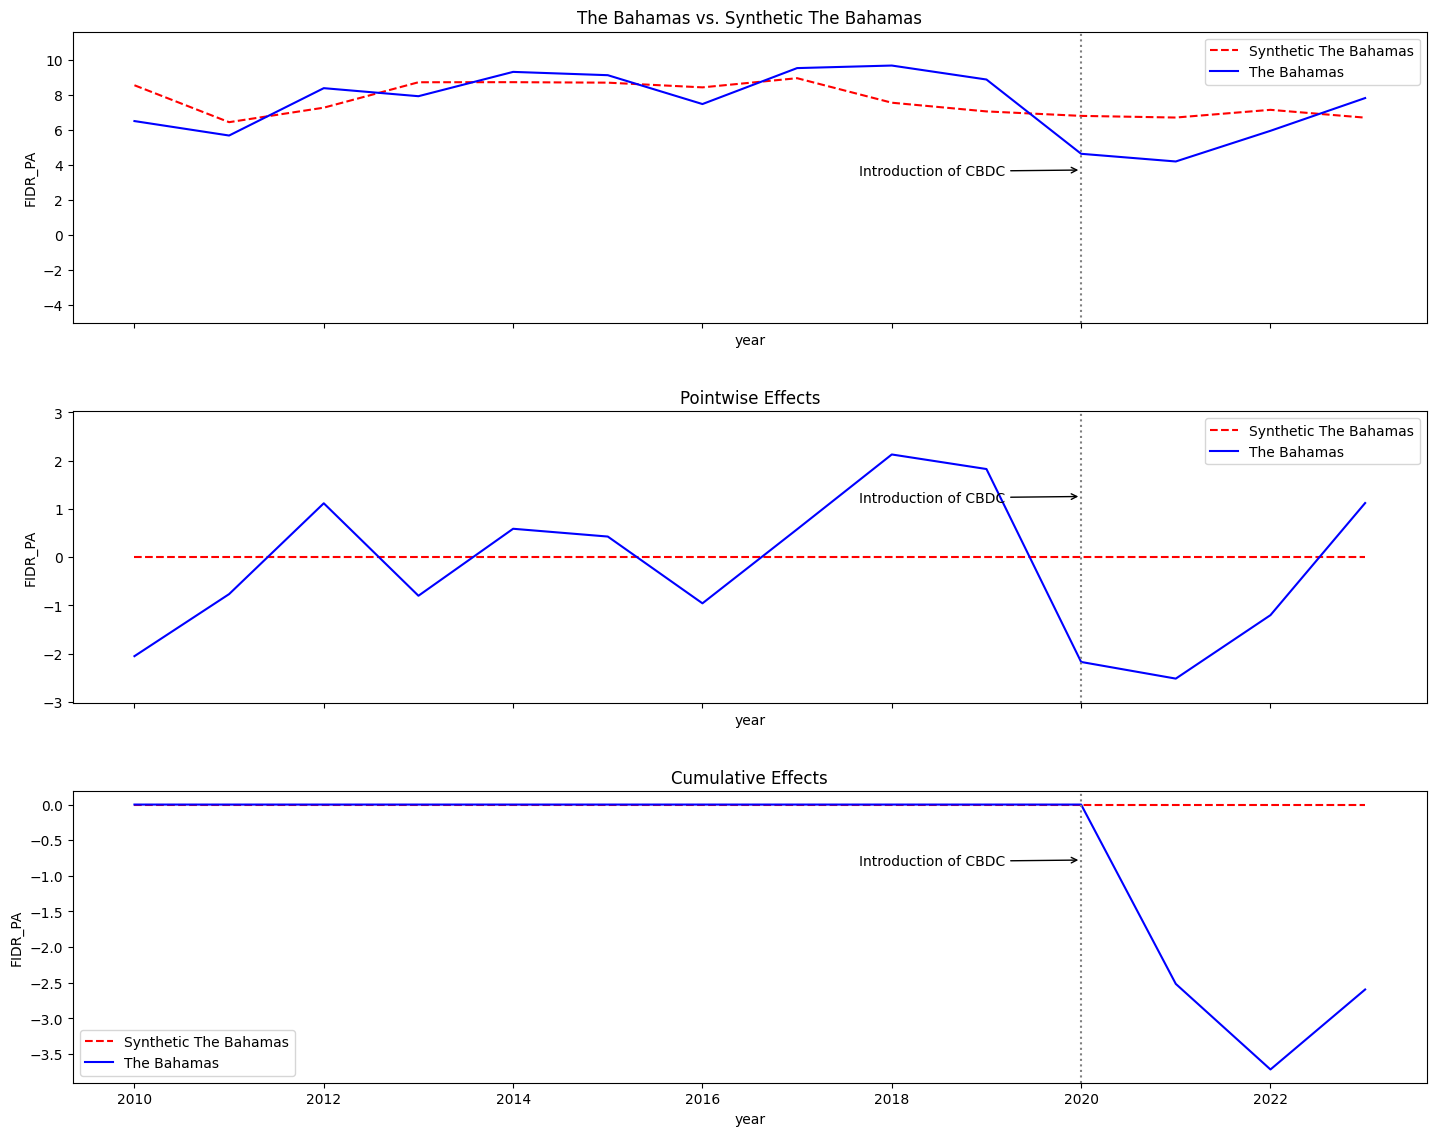

In [328]:
# SYNTHETIC CONTROL

#Import packages
import pandas as pd
from SyntheticControlMethods import Synth, DiffSynth

#Import data
file_path = 'data/synthetic-control-dataset.csv'
data = pd.read_csv(file_path)
data = data.drop(columns="code", axis=1)

#Fit classic Synthetic Control
sc = Synth(data, "FIDR_PA", "country", "year", 2021, "NG", pen=0)
# dsc = DiffSynth(data, "FIDR_PA", "country", "year", 2020, "BS", not_diff_cols=["NGDP_XDC","PCPI_IX","FITB_PA","FISR_PA","FILR_PA"], pen="auto")

print("\nSynthetic Control Wieghts")
print(sc.original_data.weight_df)

#Visualize synthetic control
sc.plot(["original", "pointwise", "cumulative"], treated_label="The Bahamas", synth_label="Synthetic The Bahamas", treatment_label="Introduction of CBDC")

In [129]:
from pprint import pprint
pprint(vars(sc.original_data))

{'comparison_df':                      BS  Synthetic BS  WMAPE  Importance
FIDR_PA            3.50          3.55   0.34        0.08
NGDP_XDC           2.17          2.31   1.48        0.06
PCPI_IX            2.10          3.02   0.92        0.14
ENDE_XDC_USD_RATE  1.00          2.96   1.96        0.08
FITB_PA            2.32          4.66   2.34        0.32
FISR_PA            2.49          3.67   1.33        0.33
FILR_PA            5.89          9.73   3.84        0.00,
 'control_covariates': array([[ 1.29332322,  1.35375416,  1.73029555,  1.16938587,  1.93547525,
         1.17500813,  1.10190492,  1.08676972,  1.29357714],
       [ 1.39128517,  0.38678688,  1.27072308,  0.19010607,  2.5760249 ,
         1.40160285,  1.1223811 , -0.62796434,  1.2724527 ],
       [ 0.60017766,  1.37929897,  0.43072973,  0.55576517,  1.48141924,
         0.77649248,  0.67841502,  1.32937225,  0.84375744],
       [ 0.92979187,  0.80714146,  0.53681924,  0.94010812,  0.83202001,
         1.03395868,  3.638

BS - FIDR_PA - A
{'@FREQ': 'A', '@REF_AREA': 'BS', '@INDICATOR': 'FIDR_PA', '@UNIT_MULT': '0', '@TIME_FORMAT': 'P1Y', 'Obs': [{'@TIME_PERIOD': '1985', '@OBS_VALUE': '6.39833333333333'}, {'@TIME_PERIOD': '1986', '@OBS_VALUE': '5.57'}, {'@TIME_PERIOD': '1987', '@OBS_VALUE': '5.5'}, {'@TIME_PERIOD': '1988', '@OBS_VALUE': '5.97'}, {'@TIME_PERIOD': '1989', '@OBS_VALUE': '6.48333333333333'}, {'@TIME_PERIOD': '1990', '@OBS_VALUE': '6.57083333333333'}, {'@TIME_PERIOD': '1991', '@OBS_VALUE': '6.91666666666667'}, {'@TIME_PERIOD': '1992', '@OBS_VALUE': '6.13333333333333'}, {'@TIME_PERIOD': '1993', '@OBS_VALUE': '5.19'}, {'@TIME_PERIOD': '1994', '@OBS_VALUE': '4.30083333333333'}, {'@TIME_PERIOD': '1995', '@OBS_VALUE': '4.19666666666667'}, {'@TIME_PERIOD': '1996', '@OBS_VALUE': '5.13583333333333'}, {'@TIME_PERIOD': '1997', '@OBS_VALUE': '5.22833333333333'}, {'@TIME_PERIOD': '1998', '@OBS_VALUE': '5.3625'}, {'@TIME_PERIOD': '1999', '@OBS_VALUE': '4.5725'}, {'@TIME_PERIOD': '2000', '@OBS_VALUE': '4.0

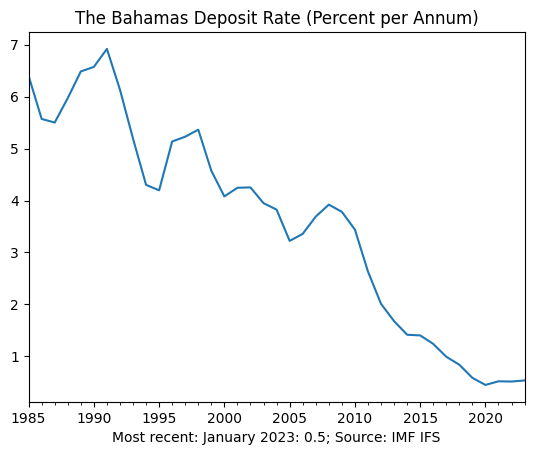

In [291]:

import requests # Python 3.6
import pandas as pd # pandas version 0.23

FREQUENCY = 'A' # 'M' for monthly, 'Q' for quarterly, 'A' for annual
COUNTRY = 'BS' # ISO country code
INDICATOR = 'FIDR_PA' # 'FIDR_PA' for Interest Rates, Deposit Interest

url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
key = f'CompactData/IFS/{FREQUENCY}.{COUNTRY}.{INDICATOR}'

# Navigate to series in API-returned JSON data
data = (requests.get(f'{url}{key}').json()
        ['CompactData']['DataSet']['Series'])

print(f"{COUNTRY} - {INDICATOR} - {FREQUENCY}")
print(data)

# Create pandas dataframe from the observations
data_list = [[obs.get('@TIME_PERIOD'), obs.get('@OBS_VALUE')] for obs in data['Obs']]

df = pd.DataFrame(data_list, columns=['date', 'value'])
df = df.set_index(pd.to_datetime(df['date']))['value'].astype('float')

# Save cleaned dataframe as a csv file
df.to_csv(f'data/{FREQUENCY}-{COUNTRY}-{INDICATOR}.csv', header=True)

# Title and text with recent value
title = 'The Bahamas Deposit Rate (Percent per Annum)'
recentdt = df.index[-1].strftime('%B %Y')
recentval = round(df[-1], 1)
recent = f'Most recent: {recentdt}: {recentval}'
source = 'Source: IMF IFS'

# Basic plot
plot = df.plot(title=title)
plot = plot.set_xlabel(f'{recent}; {source}')

In [ ]:
# EXAMPLE CODE IMF DATA API

# import pandas as pd          # pandas version 0.23

# baseyr = data['@BASE_YEAR']  # Save the base year

# # Create pandas dataframe from the observations
# data_list = [[obs.get('@TIME_PERIOD'), obs.get('@OBS_VALUE')]
#              for obs in data['Obs']]

# df = pd.DataFrame(data_list, columns=['date', 'value'])

# df = df.set_index(pd.to_datetime(df['date']))['value'].astype('float')

# # Save cleaned dataframe as a csv file
# df.to_csv('data/UK_import_price_index.csv', header=True)

# # Title and text with recent value
# title = f'U.K. Import Prices (index, {baseyr})'
# recentdt = df.index[-1].strftime('%B %Y')
# recentval = round(df[-1], 1)
# recent = f'Most recent: {recentdt}: {recentval}'
# source = 'Source: IMF IFS'

# # Basic plot
# plot = df.plot(title=title, colormap='Set1')
# plot = plot.set_xlabel(f'{recent}; {source}')